# 1) Face Recognition

Two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 

- **Face Recognition** - "who is this person?". For Example, employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem. 

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from lib.fr_utils import *
from lib.inception_blocks_v2 import *
np.set_printoptions(threshold=np.nan)
K.set_image_data_format('channels_first')

## 1.1 Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, it may be the same person.

* Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on. 
* You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.  
* By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/images/pixel_comparison.png?raw=true" style="width:380px;height:150px;">

## 1.2 Encoding face images into a 128-dimensional vector using Covnet

The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). Refer to `inception_blocks_v2.py` for inception network implementation.

The key things you need to know are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

In [ ]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))
print("Total Params:", FRmodel.count_params())

Total Params: 3743280


By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. You then use the encodings to compare two face images as follows:

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/images/distance_kiank.png?raw=true" style="width:680px;height:250px;">

So, an encoding is a good one if: 
- The encodings of two images of the same person are quite similar to each other. 
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart. 

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/images/triplet_comparison.png?raw=true" style="width:280px;height:150px;">

## 1.3 The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/images/f_x.png?raw=true" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
- $\alpha$ is called the margin. It is a hyperparameter that you pick manually. We will use $\alpha = 0.2$. 

In [ ]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)    
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)    
    basic_loss = pos_dist - neg_dist + alpha
    
    # Take the maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    return loss

In [ ]:
with tf.Session() as test:
    tf.set_random_seed(1)
    y_true = (None, None, None)
    y_pred = (tf.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
              tf.random_normal([3, 128], mean=1, stddev=1, seed = 1),
              tf.random_normal([3, 128], mean=3, stddev=4, seed = 1))
    loss = triplet_loss(y_true, y_pred)
    print("loss = " + str(loss.eval()))

loss = 528.143


## 1.4 Loading the pre-trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 

In [ ]:
FRmodel.compile(optimizer='adam', loss=triplet_loss, metrics=['accuracy'])
load_weights_from_FaceNet(FRmodel)

Here are some examples of distances between the encodings between three individuals:

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/images/distance_matrix.png?raw=true" style="width:380px;height:200px;">

### 1.4.2 Face Verification

Let's build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding we use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image. 

Now, when someone shows up at your front door and swipes their ID card (thus giving you their name), you can look up their encoding in the database, and use it to check if the person standing at the front door matches the name on the ID.

In [ ]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

In [ ]:
def verify(image_path, identity, database, model):
    
    # Step 1: Compute the encoding for the image.
    encoding = img_to_encoding(image_path, model)
    
    # Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    # Step 3: Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
                
    return dist, door_open

In [ ]:
verify("images/camera_0.jpg", "younes", database, FRmodel)

It's younes, welcome in!


(0.65939289, True)

### 1.4.2 Face Recognition

Implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as one of the inputs. 

In [ ]:
def who_is_it(image_path, database, model):
    
    encoding = img_to_encoding(image_path, model)
    
    # Find the closest encoding
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance
        dist = np.linalg.norm(encoding - db_enc)
        # If this distance is less than the min_dist, then set min_dist to dist
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

In [ ]:
who_is_it("images/camera_0.jpg", database, FRmodel)

it's younes, the distance is 0.659393


(0.65939289, 'younes')

**Key points to remember**

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem. 
- The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 

# 2) Application

In [ ]:
pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.9 MB/s 


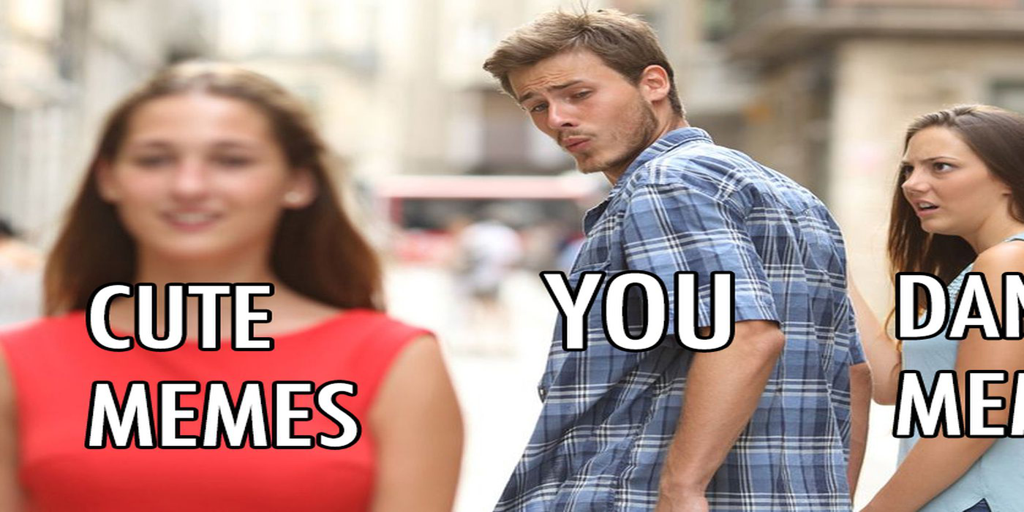

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# If required, create a face detection pipeline using MTCNN
# keep all to detect all face
mtcnn = MTCNN(keep_all=True)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

response = requests.get("https://cdn.vox-cdn.com/thumbor/-5QeCxdkh-7dEypKEonW8KEIvX0=/1400x1050/filters:format(jpeg)/cdn.vox-cdn.com/uploads/chorus_asset/file/13207789/hey.jpg")
img = Image.open(BytesIO(response.content))
img.resize((1024, 512))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 3, 160, 160])


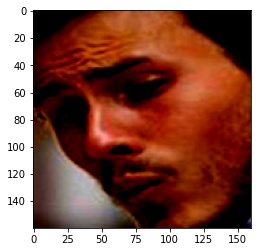

In [ ]:
# cropped detected face
img_cropped = mtcnn(img)
print(img_cropped.shape)
image = img_cropped[1]
plt.imshow(image.permute(1, 2, 0))

In [ ]:
# calculate distance between 2 embedding
img_embedding_1 = resnet(img_cropped[1].unsqueeze(0)).detach().numpy()
img_embedding_2 = resnet(img_cropped[2].unsqueeze(0)).detach().numpy()
print(img_embedding_1.shape)
print(np.linalg.norm(img_embedding_1 - img_embedding_2))

(1, 512)
1.3705281


In [ ]:
def calculate_dist(img_1, img2):
    mtcnn = MTCNN()
    img_cropped_1 = mtcnn(img_1)
    img_cropped_2 = mtcnn(img2)

    img_embedding_1 = resnet(img_cropped_1.unsqueeze(0)).detach().numpy()
    img_embedding_2 = resnet(img_cropped_2.unsqueeze(0)).detach().numpy()
    dist = np.linalg.norm(img_embedding_1 - img_embedding_2)

    if dist <= 0.7:
        print("Image Match")
    else:
        print("Image not Match")

    return dist

In [ ]:
response = requests.get("https://api.time.com/wp-content/uploads/2014/03/479748569.jpg")
img_chris_1 = Image.open(BytesIO(response.content))

response = requests.get("https://www.eatthis.com/wp-content/uploads/sites/4/2022/06/Chris-Evans.jpg?quality=82&strip=all")
img_chris_2 = Image.open(BytesIO(response.content))

response = requests.get("https://m.media-amazon.com/images/M/MV5BMTg0NTI0NDkzOF5BMl5BanBnXkFtZTcwMjYwMTIwNw@@._V1_.jpg")
img_michelle = Image.open(BytesIO(response.content))

print(calculate_dist(img_chris_1, img_chris_2))
print("\n")
print(calculate_dist(img_chris_1, img_michelle))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Image Match
0.54090065


Image not Match
1.3906147


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


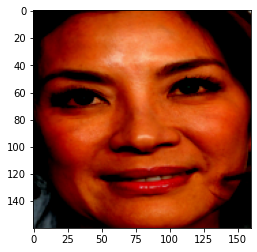

In [ ]:
# cropped detected face
img_sample = mtcnn(img_michelle)
plt.imshow(img_sample[0].permute(1, 2, 0))